# Review of gait-related mobile EEG preprocessing steps — Data Preparation & Visualization

This notebook organizes and visualizes data extracted from the literature via **Elicit**, focusing on experimental and preprocessing parameters relevant to mobile EEG during gait.

Our goals here are to:
- Structure all study-level data into a clean DataFrame  
- Explore distributions of cohorts, gait measurement systems, and artifact rejection methods  
- Generate simple, clear, and reproducible plots for the manuscript and supplementary materials  


## Setup

We'll start by importing necessary packages and defining paths.  
The notebook assumes the CSV file exported from Elicit is available in the `../data/` directory.


In [1]:
import pandas as pd
import numpy as np
import ast
import os
import itertools
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.patches import Patch, FancyArrowPatch
from matplotlib.lines import Line2D
from math import sqrt
from upsetplot import UpSet, from_indicators

from utils.config import define_dir, dir_processed


## Configure the directories

In [15]:
# Get the current directory where the script is executed
dir_proj = Path.cwd()

# Define the paths for 'logs' and 'results' directories
dir_log_results = define_dir(dir_proj, "logs")  # Logs directory path
dir_results = define_dir(dir_proj, "results")  # Results directory path
dir_fulltexts = define_dir(dir_results, "fulltexts")  # Full-text articles directory path
dir_researcharticles = define_dir(dir_results, "researcharticles")  # Research articles directory path
dir_methods = define_dir(dir_results, "methods")  # Methods sections directory path
dir_data = define_dir(dir_proj, "data") # Data directory path
dir_processed = define_dir(dir_results, "cleanresults") # Processed data directory

## 1. Load the dataset

We’ll start by loading the extracted dataset (`Elicitrevised.csv`), which contains:
- Metadata (Title, Citation, Filename)
- Experimental details (Cohort, Gait Task, EEG Type)
- Preprocessing details and artifact rejection methods

Since some fields include multiple values (e.g., multiple gait systems or methods),  
we’ll clean those for easy downstream use.


In [16]:
data_path = Path("data/20251003_Elicitrevised.csv")
df = pd.read_csv(data_path, sep=";")
print(f"Loaded {len(df)} studies")
df.head(3)

Loaded 67 studies


,Title,Citation,Filename,Cohort,Gait Task,Dual-layer cap,Type of EEG electrodes,Gait measurement system,Flow of preprocessing steps,step_keywords,Artifactrej_methods,outcome_keywords_script
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",PMC11162180.pdf,Healthy adults,Treadmill walking,Yes,Active electrodes,Force plates;OMC,1. High-pass filtering at 1 Hz to attenuate sl...,"['Raw data', 'High-pass filter', 'Re-reference...","iCanClean, clean_artifacts, Bad channel removal","['PSD', 'ERSP', 'ERD/ERS']"
1,Study of the Brain Functional Connectivity Pro...,"Wei, P., et al., 2024",PMC11548552.pdf,Healthy adults,Treadmill walking,No,Active electrodes,OMC,1. Excluded reference and EOG channels.\r\n2. ...,"['Raw data', 'Channel removal', 'Bandpass filt...","ASR, Bad channel removal, Eye artifact removal","['PSD', 'ERD/ERS']"
2,Exploring Electrocortical Signatures of Gait A...,"Jacobsen, N. A., et al., 2024",PMC11242882.pdf,Healthy adults,Treadmill walking,Yes,Active electrodes,Force plates;OMC,1. High-pass filtering at 1 Hz to mitigate slo...,"['Raw data','High-pass filter','Artifact Rejec...","iCanClean, clean_artifacts, clean_rawdata, Bad...","['ERSP', 'ERD/ERS']"


## Step 2: Organize Data into Structured DataFrames

In this section, we will:
- Clean and standardize text fields.
- Separate parameters with multiple values (e.g., gait systems, artifact rejection methods).
- Create easy-to-analyze DataFrames for:
  - Cohort
  - Gait Task
  - EEG Electrode Type
  - Gait Measurement System
  - Artifact Rejection Methods
  - Preprocessing Steps
  - Outcomes

Each DataFrame will have one row per study per method/system, in order to plot them.
Some columns (e.g., `Gait_measurement_system`) contain multiple entries separated by `;` or `,`.
We will:
- Split them into lists.
- Explode these lists into separate rows.
This will make it possible to count and visualize occurrences of each system or method across studies.


In [17]:
# Standardize column names
df.columns = (
    df.columns.str.strip()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

# Clean text fields
text_cols = [
    "Cohort", "Gait_Task", "Dual_layer_cap",
    "Type_of_EEG_electrodes", "Gait_measurement_system",
    "Artifactrej_methods", "step_keywords", "outcome_keywords_script"
]

for col in text_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(r"[\r\n]+", " ", regex=True)
            .str.strip()
        )

# --- Convert invalid values to NaN ---
df.replace(["", "nan", "None", "NaN"], np.nan, inplace=True)

# --- Drop duplicates and empty rows ---
df = df.drop_duplicates().dropna(how="all")

# --- Utility to clean and explode multi-value columns ---
def split_and_clean(df, col):
    """Split semicolon/list-like column into multiple rows."""
    if col not in df.columns:
        print(f"Column '{col}' not found.")
        return pd.DataFrame(columns=["Title", "Citation", col])
    temp = df[["Title", "Citation", col]].copy()
    temp[col] = temp[col].astype(str).str.replace(r"[\[\]']", "", regex=True)
    temp[col] = temp[col].str.split(";|,")
    temp = temp.explode(col)
    temp[col] = temp[col].str.strip()
    temp = temp[temp[col].notna() & (temp[col] != "")]
    return temp

print("Data cleaned and normalized.")
df.head(3)


Data cleaned and normalized.


,Title,Citation,Filename,Cohort,Gait_Task,Dual_layer_cap,Type_of_EEG_electrodes,Gait_measurement_system,Flow_of_preprocessing_steps,step_keywords,Artifactrej_methods,outcome_keywords_script
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",PMC11162180.pdf,Healthy adults,Treadmill walking,Yes,Active electrodes,Force plates;OMC,1. High-pass filtering at 1 Hz to attenuate sl...,"['Raw data', 'High-pass filter', 'Re-reference...","iCanClean, clean_artifacts, Bad channel removal","['PSD', 'ERSP', 'ERD/ERS']"
1,Study of the Brain Functional Connectivity Pro...,"Wei, P., et al., 2024",PMC11548552.pdf,Healthy adults,Treadmill walking,No,Active electrodes,OMC,1. Excluded reference and EOG channels.\r\n2. ...,"['Raw data', 'Channel removal', 'Bandpass filt...","ASR, Bad channel removal, Eye artifact removal","['PSD', 'ERD/ERS']"
2,Exploring Electrocortical Signatures of Gait A...,"Jacobsen, N. A., et al., 2024",PMC11242882.pdf,Healthy adults,Treadmill walking,Yes,Active electrodes,Force plates;OMC,1. High-pass filtering at 1 Hz to mitigate slo...,"['Raw data','High-pass filter','Artifact Rejec...","iCanClean, clean_artifacts, clean_rawdata, Bad...","['ERSP', 'ERD/ERS']"


In [18]:
# --- Split all relevant columns ---
df_cohort = split_and_clean(df, "Cohort")
df_gait_task = split_and_clean(df, "Gait_Task")
df_gait_system = split_and_clean(df, "Gait_measurement_system")
df_artifact = split_and_clean(df, "Artifactrej_methods")
df_eeg_electrodes = split_and_clean(df, "Type_of_EEG_electrodes")
df_step_keywords = split_and_clean(df, "step_keywords")
df_outcomes = split_and_clean(df, "outcome_keywords_script")

# --- Summary ---
print("Summary of entries:")
print(f"Cohort entries: {len(df_cohort)}")
print(f"Gait task entries: {len(df_gait_task)}")
print(f"Gait systems entries: {len(df_gait_system)}")
print(f"Artifact rejection entries: {len(df_artifact)}")
print(f"EEG electrode entries: {len(df_eeg_electrodes)}")
print(f"Step keyword entries: {len(df_step_keywords)}")
print(f"Outcome keyword entries: {len(df_outcomes)}")



Summary of entries:
Cohort entries: 67
Gait task entries: 67
Gait systems entries: 86
Artifact rejection entries: 153
EEG electrode entries: 69
Step keyword entries: 573
Outcome keyword entries: 141


In [19]:
export_tables = {
    "Cohort": df_cohort,
    "Gait_Task": df_gait_task,
    "Gait_System": df_gait_system,
    "Artifact_Methods": df_artifact,
    "EEG_Electrodes": df_eeg_electrodes,
    "Step_Keywords": df_step_keywords,
    "Outcome_Keywords": df_outcomes
}

for name, table in export_tables.items():
    out_path = os.path.join(dir_processed, f"{name}_cleaned.csv")
    table.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


Saved: c:\Vaishali\NG\MobileEEG\Litreview\LitExtract\results\cleanresults\Cohort_cleaned.csv
Saved: c:\Vaishali\NG\MobileEEG\Litreview\LitExtract\results\cleanresults\Gait_Task_cleaned.csv
Saved: c:\Vaishali\NG\MobileEEG\Litreview\LitExtract\results\cleanresults\Gait_System_cleaned.csv
Saved: c:\Vaishali\NG\MobileEEG\Litreview\LitExtract\results\cleanresults\Artifact_Methods_cleaned.csv
Saved: c:\Vaishali\NG\MobileEEG\Litreview\LitExtract\results\cleanresults\EEG_Electrodes_cleaned.csv
Saved: c:\Vaishali\NG\MobileEEG\Litreview\LitExtract\results\cleanresults\Step_Keywords_cleaned.csv
Saved: c:\Vaishali\NG\MobileEEG\Litreview\LitExtract\results\cleanresults\Outcome_Keywords_cleaned.csv


In [20]:
files = {
    "Cohort": "results/cleanresults/Cohort_cleaned.csv",
    "Gait_Task": "results/cleanresults/Gait_Task_cleaned.csv",
    "Gait_System": "results/cleanresults/Gait_System_cleaned.csv",
    "EEG_Electrodes": "results/cleanresults/EEG_Electrodes_cleaned.csv",
    "Step_Keywords": "results/cleanresults/Step_Keywords_cleaned.csv",
    "Artifact_Methods": "results/cleanresults/Artifact_Methods_cleaned.csv",
    "Outcome_Keywords": "results/cleanresults/Outcome_Keywords_cleaned.csv"
}

dfs = {name: pd.read_csv(path, dtype=str).fillna("") for name, path in files.items()}

# Check sizes
for name, df in dfs.items():
    print(f"{name}: {df.shape[0]} rows × {df.shape[1]} cols")


Cohort: 67 rows × 3 cols
Gait_Task: 67 rows × 3 cols
Gait_System: 86 rows × 3 cols
EEG_Electrodes: 69 rows × 3 cols
Step_Keywords: 573 rows × 3 cols
Artifact_Methods: 153 rows × 3 cols
Outcome_Keywords: 141 rows × 3 cols


In [21]:
display(df_cohort.head(3))
display(df_artifact.head(3))
display(df_step_keywords.head(3))


,Title,Citation,Cohort
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",Healthy adults
1,Study of the Brain Functional Connectivity Pro...,"Wei, P., et al., 2024",Healthy adults
2,Exploring Electrocortical Signatures of Gait A...,"Jacobsen, N. A., et al., 2024",Healthy adults


,Title,Citation,Artifactrej_methods
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",iCanClean
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",clean_artifacts
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",Bad channel removal


,Title,Citation,step_keywords
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",Raw data
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",High-pass filter
0,Electrocortical theta activity may reflect sen...,"Jacobsen, N.A., et al., 2024",Re-reference


In [22]:
# Check for missing values
master_titles = set(dfs["Cohort"]["Title"])
for name, df in dfs.items():
    missing = master_titles - set(df["Title"])
    extra = set(df["Title"]) - master_titles
    print(f"{name}: missing {len(missing)}, extra {len(extra)}")


Cohort: missing 0, extra 0
Gait_Task: missing 0, extra 0
Gait_System: missing 0, extra 0
EEG_Electrodes: missing 0, extra 0
Step_Keywords: missing 0, extra 0
Artifact_Methods: missing 0, extra 0
Outcome_Keywords: missing 0, extra 0


In [11]:
# Aggregate steps
steps_grouped = (
    dfs["Step_Keywords"]
    .groupby(["Title", "Citation"])["step_keywords"]
    .apply(lambda x: list(set(x.dropna())))
    .reset_index()
)

# Aggregate outcomes
outcomes_grouped = (
    dfs["Outcome_Keywords"]
    .groupby(["Title", "Citation"])["outcome_keywords_script"]
    .apply(lambda x: list(set(x.dropna())))
    .reset_index()
)

# Merge core datasets
meta = dfs["Cohort"][["Title", "Citation", "Cohort"]].merge(
    dfs["Gait_Task"][["Title", "Gait_Task"]], on="Title", how="left"
)
meta = meta.merge(dfs["Gait_System"][["Title", "Gait_measurement_system"]], on="Title", how="left")
meta = meta.merge(dfs["EEG_Electrodes"][["Title", "Type_of_EEG_electrodes"]], on="Title", how="left")
meta = meta.merge(steps_grouped, on="Title", how="left")
meta = meta.merge(outcomes_grouped, on="Title", how="left")

print(f"✅ Combined dataset: {meta.shape[0]} studies")


✅ Combined dataset: 88 studies


### Creating Clean DataFrames for Each Parameter

Now we’ll create structured DataFrames for:
- `Cohort`
- `Gait_Task`
- `Gait_measurement_system` (exploded)
- `Type_of_EEG_electrodes` (exploded)
- `Artifactrej_methods` (exploded)

These will be stored in a dictionary for easy iteration during plotting or export.


In [20]:
available_files = list(dir_processed.glob("*.csv"))
print("Available processed CSV files:")
for f in available_files:
    print("-", f.name)

processed_data = {f.stem: pd.read_csv(f) for f in available_files}

for name, df in processed_data.items():
    print(f"\n{name.upper()}: {df.shape[0]} rows × {df.shape[1]} cols")
    print(df.head(3))


Available processed CSV files:
- Artifact_Methods_cleaned.csv
- Cohort_cleaned.csv
- EEG_Electrodes_cleaned.csv
- Gait_System_cleaned.csv
- Gait_Task_cleaned.csv
- Outcome_Keywords_cleaned.csv
- Step_Keywords_cleaned.csv

ARTIFACT_METHODS_CLEANED: 153 rows × 3 cols
                                               Title  \
0  Electrocortical theta activity may reflect sen...   
1  Electrocortical theta activity may reflect sen...   
2  Electrocortical theta activity may reflect sen...   

                       Citation  Artifactrej_methods  
0  Jacobsen, N.A., et al., 2024            iCanClean  
1  Jacobsen, N.A., et al., 2024      clean_artifacts  
2  Jacobsen, N.A., et al., 2024  Bad channel removal  

COHORT_CLEANED: 67 rows × 3 cols
                                               Title  \
0  Electrocortical theta activity may reflect sen...   
1  Study of the Brain Functional Connectivity Pro...   
2  Exploring Electrocortical Signatures of Gait A...   

                        Citati

In [21]:
# Rebuild pipelines per study

grouped_steps = df_step_keywords.groupby("Title")["step_keywords"].apply(list).reset_index()
grouped_outcomes = df_outcomes.groupby("Title")["outcome_keywords_script"].apply(list).reset_index()

merged = pd.merge(grouped_steps, grouped_outcomes, on="Title", how="outer", suffixes=("_steps", "_outcomes"))
merged["step_keywords"] = merged["step_keywords"].apply(lambda x: x if isinstance(x, list) else [])
merged["outcome_keywords_script"] = merged["outcome_keywords_script"].apply(lambda x: x if isinstance(x, list) else [])

print(f"Reconstructed {len(merged)} study pipelines.")
display(merged.head(3))


Reconstructed 67 study pipelines.


,Title,step_keywords,outcome_keywords_script
0,A Channel Rejection Method for Attenuating Mot...,"[Raw data, High-pass filter, Notch filter, Art...","[ERSP, ERD/ERS]"
1,A walk in the park? Characterizing gait-relate...,"[Raw data, High-pass filter, Low-pass filter, ...","[ERSP, ERD/ERS]"
2,Alteration of brain dynamics during dual-task ...,"[Raw data, Bandpass filter, Downsample, Bad ch...","[PSD, ERD/ERS]"


### Exporting Structured Data

We’ll now save each structured DataFrame into the project’s `data/processed_data` directory.

The base data directory (`dir_data`) is already defined in `utils.config`.  
This ensures that file paths remain consistent across scripts, notebooks, and collaborators.

Each structured dataset will be exported as a CSV file and versioned for reproducibility.



## Load Processed Data for Visualization

Now that the preprocessing and organization are done,  
we’ll load the processed CSV files (e.g., cohort, gait task, electrode type, etc.)  
from the `results/cleanresults` folder for visualization.


In [22]:
# --- Data verification cell ---
import os
import pandas as pd

processed_files = [
    "Cohort_cleaned.csv",
    "Gait_Task_cleaned.csv",
    "Gait_System_cleaned.csv",
    "EEG_Electrodes_cleaned.csv",
    "Step_Keywords_cleaned.csv",
    "Artifact_Methods_cleaned.csv",
    "Outcome_Keywords_cleaned.csv"
]

print("✅ Checking processed data structure...\n")
for f in processed_files:
    path = os.path.join(dir_processed, f)
    if os.path.exists(path):
        df_temp = pd.read_csv(path)
        print(f"{f}: {df_temp.shape[0]} rows × {df_temp.shape[1]} cols")
        print(" Columns:", list(df_temp.columns))
        print(" Sample:\n", df_temp.head(2), "\n")
    else:
        print(f"⚠️ Missing file: {f}")


✅ Checking processed data structure...

Cohort_cleaned.csv: 67 rows × 3 cols
 Columns: ['Title', 'Citation', 'Cohort']
 Sample:
                                                Title  \
0  Electrocortical theta activity may reflect sen...   
1  Study of the Brain Functional Connectivity Pro...   

                       Citation          Cohort  
0  Jacobsen, N.A., et al., 2024  Healthy adults  
1         Wei, P., et al., 2024  Healthy adults   

Gait_Task_cleaned.csv: 67 rows × 3 cols
 Columns: ['Title', 'Citation', 'Gait_Task']
 Sample:
                                                Title  \
0  Electrocortical theta activity may reflect sen...   
1  Study of the Brain Functional Connectivity Pro...   

                       Citation          Gait_Task  
0  Jacobsen, N.A., et al., 2024  Treadmill walking  
1         Wei, P., et al., 2024  Treadmill walking   

Gait_System_cleaned.csv: 86 rows × 3 cols
 Columns: ['Title', 'Citation', 'Gait_measurement_system']
 Sample:
               

## Prepare Aggregated Data for Visualization

Next, let’s prepare frequency tables and summary data.  
For example, how many studies used each gait measurement system,  
EEG electrode type, and artifact rejection method.


## Visualize Key Parameters

We’ll now create simple, publication-ready bar plots  
to visualize how frequently each parameter occurs across studies.

Libraries: `matplotlib` and `seaborn`.


## Distribution of Studies by Cohort and Gait Task

To understand the experimental landscape,  
we’ll visualize how different **cohorts** (e.g., healthy adults, patients)  
are distributed across various **gait tasks** (e.g., treadmill, overground, obstacle walking).  

This gives a quick view of which populations are most commonly studied  
under which walking paradigms.


C:\Users\Vaishali\AppData\Local\Temp\ipykernel_20536\3540081985.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

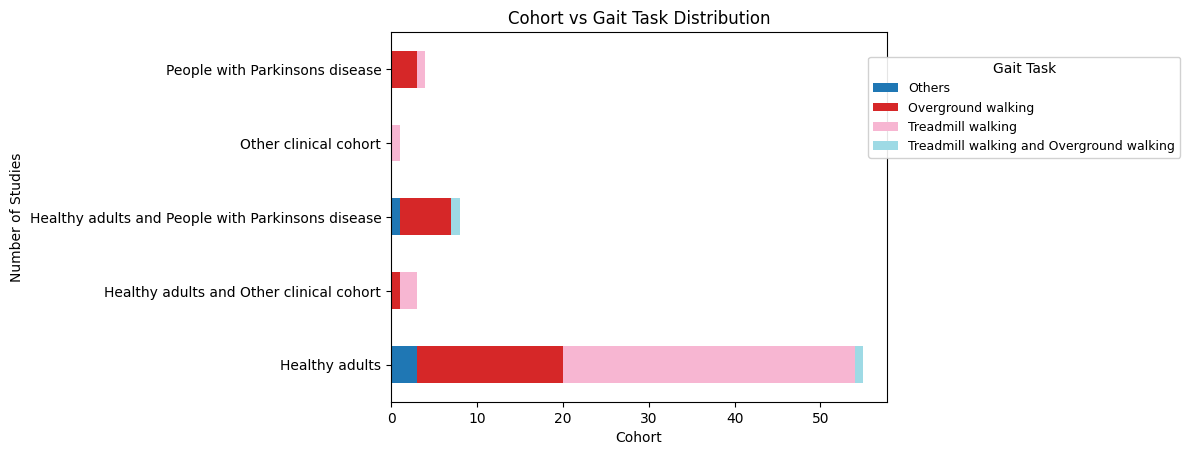

In [23]:
# Load cleaned data
df_cohort = pd.read_csv(os.path.join(dir_processed, "Cohort_cleaned.csv"))
df_gait_task = pd.read_csv(os.path.join(dir_processed, "Gait_Task_cleaned.csv"))

# Merge on Citation to align cohorts and gait tasks per study
df_cohort_task = pd.merge(df_cohort, df_gait_task, on="Citation", suffixes=("_Cohort", "_Task"))

# Count occurrences
pivot = df_cohort_task.pivot_table(index="Cohort", columns="Gait_Task", values="Citation", aggfunc="count", fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
ax = pivot.plot(kind="barh", stacked=True, colormap="tab20", edgecolor="none")
plt.title("Cohort vs Gait Task Distribution")
plt.xlabel("Cohort")
plt.ylabel("Number of Studies")
# --- Modify legend labels ---
handles, labels = ax.get_legend_handles_labels()

label_map = {
    "Overground walking": "Only Overground walking",
    "Treadmill walking": "Only Treadmill walking"
}

# Replace only matching labels
new_labels = [label_map.get(lbl, lbl) for lbl in labels]
plt.legend(title="Gait Task", bbox_to_anchor=(0.95, 0.95), loc='upper left',
    facecolor="white",
    framealpha=0.9,
    fontsize=9,
    title_fontsize=10)
plt.tight_layout()
plt.show()




C:\Users\Vaishali\AppData\Local\Temp\ipykernel_20536\3813173969.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

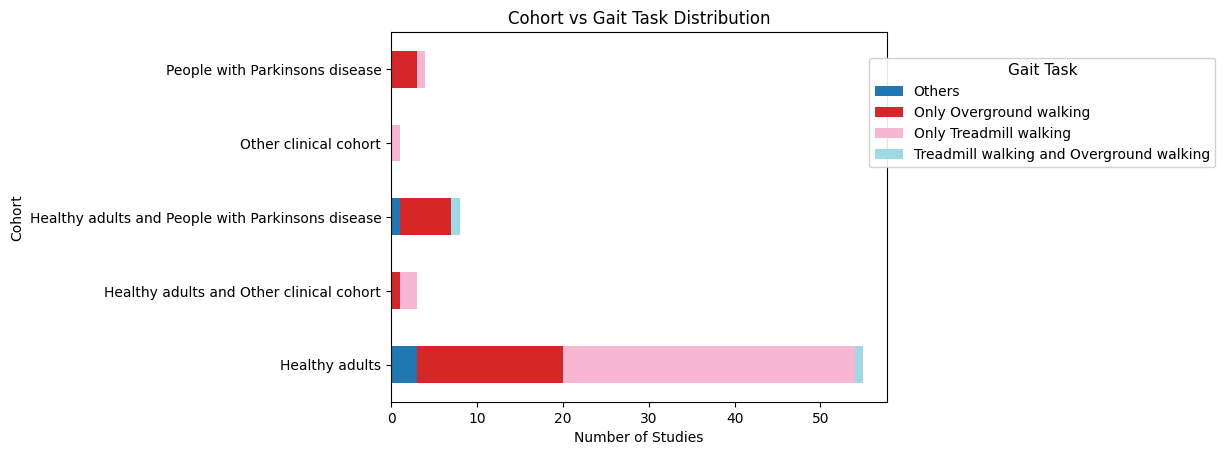

In [24]:
plt.figure(figsize=(10, 6))
ax = pivot.plot(kind="barh", stacked=True, colormap="tab20", edgecolor="none")

plt.title("Cohort vs Gait Task Distribution")
plt.xlabel("Number of Studies")
plt.ylabel("Cohort")

# --- Modify legend labels ---
handles, labels = ax.get_legend_handles_labels()

label_map = {
    "Overground walking": "Only Overground walking",
    "Treadmill walking": "Only Treadmill walking"
}

# Replace only matching labels
new_labels = [label_map.get(lbl, lbl) for lbl in labels]

# --- Place legend inside plot ---
plt.legend(
    handles,
    new_labels,
    title="Gait Task",
    loc="upper left",           # you can try 'upper right' or 'center left' depending on aesthetics
    bbox_to_anchor=(0.95, 0.95),
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    fontsize=10,
    title_fontsize=11
)

plt.tight_layout()
plt.show()


## Heatmap: EEG Electrode Type vs Gait Measurement System

We want to visualize how many studies used each combination of EEG electrode type and gait measurement system.
The heatmap shows counts for each combination.


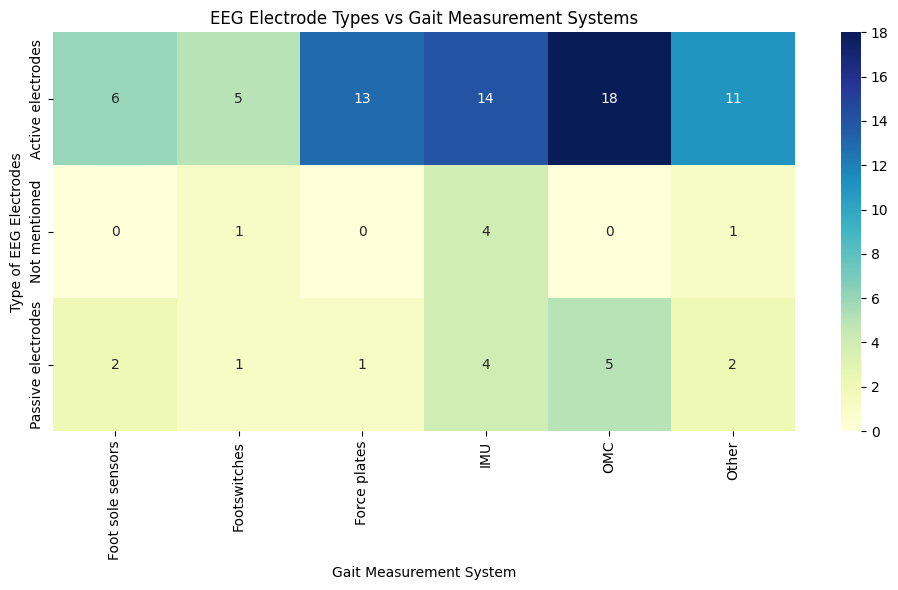

In [25]:
plt.figure(figsize=(10, 6))
heat_data = meta.groupby(["Type_of_EEG_electrodes", "Gait_measurement_system"]).size().unstack(fill_value=0)
sns.heatmap(heat_data, annot=True, cmap="YlGnBu", fmt="d")
plt.title("EEG Electrode Types vs Gait Measurement Systems")
plt.ylabel("Type of EEG Electrodes")
plt.xlabel("Gait Measurement System")
plt.tight_layout()
plt.show()


# EEG Preprocessing Network Plot
We will visualize the flow of preprocessing steps as a layered network. 
Each node represents a step, colored by stage, and arrows show transitions between steps across studies.

Lets start with importing all required libraries

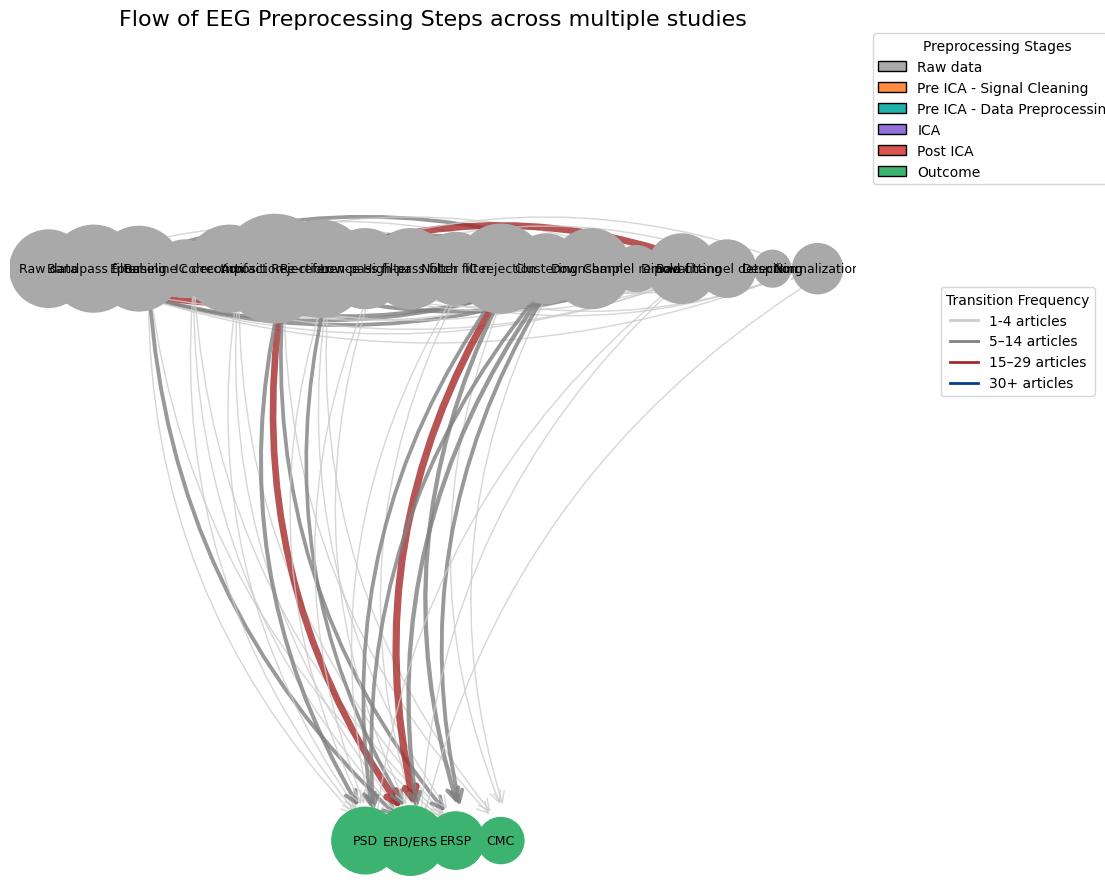

In [ ]:
# Load the two separate datasets
steps_df = pd.read_csv(os.path.join(dir_processed, "Step_Keywords_cleaned.csv"))
outcomes_df = pd.read_csv(os.path.join(dir_processed, "Outcome_Keywords_cleaned.csv"))

# Group keywords by 'Citation' into a semicolon-separated string for each file
steps_grouped = steps_df.groupby('Citation')['step_keywords'].apply(lambda x: ';'.join(x.dropna())).reset_index()
outcomes_grouped = outcomes_df.groupby('Citation')['outcome_keywords_script'].apply(lambda x: ';'.join(x.dropna())).reset_index()

# Rename the outcome column to match the original script's expectation
outcomes_grouped.rename(columns={'outcome_keywords_script': 'outcome_keywords'}, inplace=True)

# Merge the two dataframes on 'Citation'
# An outer merge ensures that articles with only steps or only outcomes are included
df = pd.merge(steps_grouped, outcomes_grouped, on='Citation', how='outer')

# Fill any missing values (NaN) with empty strings, as in the original code
df.fillna("", inplace=True)
# --- End of Data Loading and Merging Block ---


# Stage map 
stage_map = {
    "Raw data": ["Raw data"],
    "Pre ICA - Signal Cleaning": [
        "Channel removal",
        "High-pass filter", "Low-pass filter", "Bandpass filter", "Notch filter",
        "Downsample"
    ],
    "Pre ICA - Data Preprocessing": [
        "Artifact rejection", "Bad channel detection","Re-reference", "Epoching"
    ],
    "ICA": ["IC decomposition", "IC rejection"],
    "Post ICA": [
        "Clustering", "Baseline correction",
        "Dipole fitting", "Normalization" ,"Despiking"
    ],
    "Outcome": ["PSD", "ERD/ERS", "ERSP", "CMC"]
}


# Build article-wise step tracking (unchanged)
article_steps = {}
for idx, row in df.iterrows():
    paper_id = row["Citation"] if "Citation" in df.columns else idx
    steps = row["step_keywords"].split(";") if row["step_keywords"] else []
    outcomes = row["outcome_keywords"].split(";") if row["outcome_keywords"] else []
    
    # Filter out empty strings that might result from splitting
    steps = [s for s in steps if s]
    outcomes = [o for o in outcomes if o]

    full_sequence = steps + outcomes
    article_steps[paper_id] = full_sequence

# Calculate transition counts (unchanged, but now works with the merged data)
transition_counts = Counter()
for _, row in df.iterrows():
    steps = row["step_keywords"].split(";") if row["step_keywords"] else []
    outcomes = row["outcome_keywords"].split(";") if row["outcome_keywords"] else []
    
    # Filter out empty strings
    steps = [s for s in steps if s]
    outcomes = [o for o in outcomes if o]

    for i in range(len(steps) - 1):
        transition_counts[(steps[i], steps[i + 1])] += 1

    if steps and outcomes:
        last_step = steps[-1]
        for outcome in outcomes:
            transition_counts[(last_step, outcome)] += 1

# Node stage mapping (unchanged)
node_stage = {"raw_data": "Raw data"}
for stage, keys in stage_map.items():
    for key in keys:
        node_stage[key] = stage

# Setting layout (unchanged)
layer_order = [
    "Raw data",
    "Pre ICA - Signal Cleaning",
    "Pre ICA - Data Preprocessing",
    "ICA",
    "Post ICA",
    "Outcome"
]
stage_y = {stage: -i for i, stage in enumerate(layer_order)}

# Function to get node positions (unchanged)
def get_node_positions(G, node_stage, stage_map):
    positions = {}
    x_coords = defaultdict(int)

    for node in G.nodes():
        stage = node_stage.get(node, "Raw data")
        y = stage_y.get(stage, -10) 
        x = x_coords[y]
        positions[node] = (x, y)
        x_coords[y] += 1
    
    # Center the nodes in each layer
    for y_val in x_coords:
        num_nodes = x_coords[y_val]
        nodes_at_y = [node for node, pos in positions.items() if pos[1] == y_val]
        for i, node in enumerate(nodes_at_y):
            positions[node] = (i - (num_nodes - 1) / 2.0, y_val)
            
    return positions

# Plotting function (unchanged)
def plot_layered_flowchart(transition_counts, node_stage_map, stage_map, title="Flow of EEG Preprocessing Steps across multiple studies"):
    G = nx.DiGraph()
    for (src, dst), weight in transition_counts.items():
        G.add_edge(src, dst, weight=weight)

    # Add 'raw_data' if it's a source node but not in the graph yet
    if 'raw_data' not in G.nodes() and any(u == 'raw_data' for u, v in transition_counts.keys()):
        G.add_node('raw_data')

    # Color map by node stage
    color_map = {
        "Raw data": "#A9A9A9",                  # dark gray
        "Pre ICA - Signal Cleaning": "#FF8C42",  # deep orange
        "Pre ICA - Data Preprocessing": "#20B2AA",  # teal
        "ICA": "#9370DB",                       # medium purple
        "Post ICA": "#D9534F",                  # red / crimson
        "Outcome": "#3CB371",                   # medium sea green
    }

    node_colors = [color_map.get(node_stage_map.get(node, "Raw data"), "gray") for node in G.nodes()]
    node_sizes = [300 + 200 * G.degree(n) for n in G.nodes()]
    pos = get_node_positions(G, node_stage_map, stage_map)

    fig, ax = plt.subplots(figsize=(18, 12))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # Edge color and width rules
    def get_edge_style(weight):
        if weight >= 46:
            return "black", 4 + weight * 0.15
        elif weight >= 30:
            return "#023e8a", 3.8 + weight * 0.13
        elif weight >= 15:
            return "brown", 3 + weight * 0.12
        elif weight >= 5:
            return "gray", 2 + weight * 0.1
        else:
            return "#cccccc", 1.0

    # Draw arrows with arrowheads using FancyArrowPatch
    for u, v in G.edges():
        weight = G[u][v]['weight']
        color, width = get_edge_style(weight)

        start = pos[u]
        end = pos[v]
        
        node_radius = 0.3 # Adjust this based on node sizes

        # Offset calculation
        dx, dy = end[0] - start[0], end[1] - start[1]
        dist = sqrt(dx**2 + dy**2)
        if dist == 0: continue
        
        arrow_start = (start[0] + dx * node_radius / dist, start[1] + dy * node_radius / dist)
        arrow_end = (end[0] - dx * node_radius / dist, end[1] - dy * node_radius / dist)

        arrow = FancyArrowPatch(
            posA=arrow_start,
            posB=arrow_end,
            connectionstyle="arc3,rad=0.2",
            arrowstyle="->",
            mutation_scale=20,
            color=color,
            linewidth=width,
            alpha=0.8
        )
        ax.add_patch(arrow)

    # Legend 1: Node colors (stage types)
    node_legend_elements = [
        Patch(facecolor=color, edgecolor="black", label=stage)
        for stage, color in color_map.items()
    ]

    # Legend 2: Arrow colors (article frequency)
    arrow_legend_elements = [
        Line2D([0], [0], color="#cccccc", lw=2, label="1-4 articles"),
        Line2D([0], [0], color="gray", lw=2, label="5–14 articles"),
        Line2D([0], [0], color="brown", lw=2, label="15–29 articles"),
        Line2D([0], [0], color="#023e8a", lw=2, label="30+ articles")
    ]
    
    # Place the legends
    first_legend = ax.legend(handles=node_legend_elements, title="Preprocessing Stages", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    ax.add_artist(first_legend)
    ax.legend(handles=arrow_legend_elements, title="Transition Frequency", loc="upper left", bbox_to_anchor=(1.10, 0.7), borderaxespad=0.)

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout(rect=[0.1, 0.25, 0.75, 1]) 
    plt.show()

# Run plot
plot_layered_flowchart(transition_counts, node_stage, stage_map)

--- Descriptive Statistics of Preprocessing Steps ---
Total number of unique papers analyzed: 65

ERD/ERS: 65 out of 65 papers (100.00%)
PSD: 37 out of 65 papers (56.92%)
ERSP: 31 out of 65 papers (47.69%)
CMC: 5 out of 65 papers (7.69%)
--------------------------------------------------

--- Statistics of Step Transitions ---
Transition from 'IC decomposition' to 'IC rejection': 39 times
Transition from 'Artifact Rejection' to 'Re-reference': 37 times
Transition from 'ERSP' to 'ERD/ERS': 27 times
Transition from 'Artifact Rejection' to 'IC decomposition': 24 times
Transition from 'PSD' to 'ERSP': 19 times
Transition from 'PSD' to 'ERD/ERS': 18 times
Transition from 'Raw data' to 'High-pass filter': 18 times
Transition from 'Bad channel detection' to 'Artifact Rejection': 16 times
Transition from 'Raw data' to 'Bandpass filter': 15 times
Transition from 'Re-reference' to 'IC decomposition': 15 times
Transition from 'Notch filter' to 'Artifact Rejection': 14 times
Transition from 'Re-re

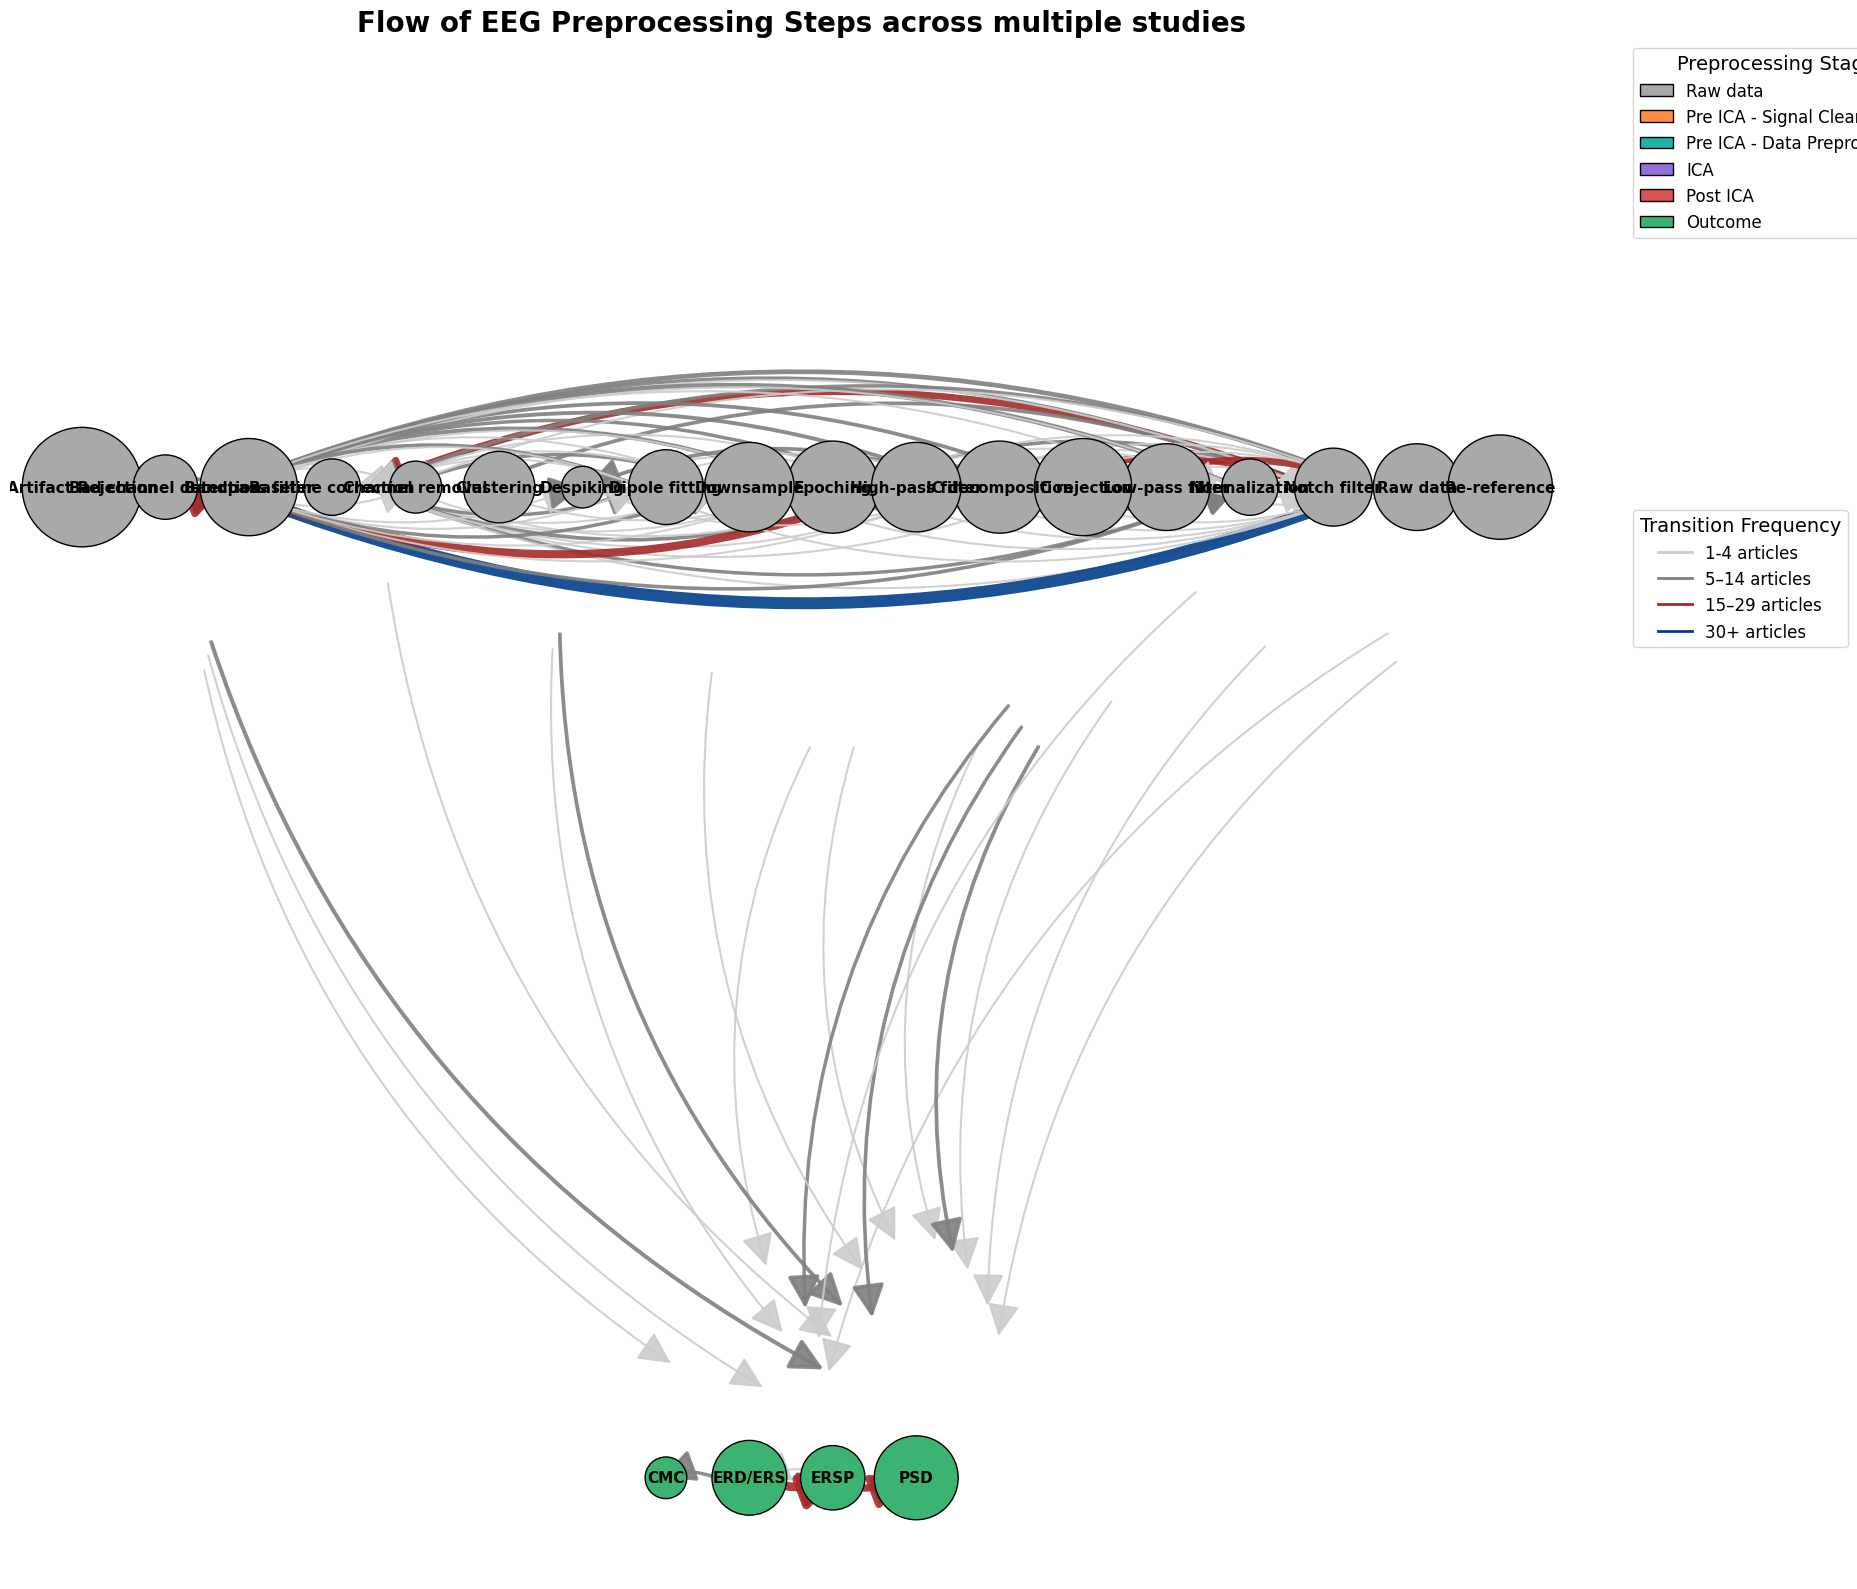

In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Patch
from matplotlib.lines import Line2D
from collections import Counter, defaultdict
from math import sqrt
import os

# --- Data Loading and Merging Block ---
# Assumes the CSV files are in the same directory as the script.
# If not, provide the full path to the files.
try:
    steps_df = pd.read_csv(os.path.join(dir_processed, "Step_Keywords_cleaned.csv"))
    outcomes_df = pd.read_csv(os.path.join(dir_processed, "Outcome_Keywords_cleaned.csv"))
except FileNotFoundError:
    print("Error: Make sure 'Step_Keywords_cleaned.csv' and 'Outcome_Keywords_cleaned.csv' are in the correct directory.")
    exit()

# Group keywords by 'Citation' into a semicolon-separated string for each file
steps_grouped = steps_df.groupby('Citation')['step_keywords'].apply(lambda x: ';'.join(x.dropna())).reset_index()
outcomes_grouped = outcomes_df.groupby('Citation')['outcome_keywords_script'].apply(lambda x: ';'.join(x.dropna())).reset_index()

# Rename the outcome column to match the original script's expectation
outcomes_grouped.rename(columns={'outcome_keywords_script': 'outcome_keywords'}, inplace=True)

# Merge the two dataframes on 'Citation'
df = pd.merge(steps_grouped, outcomes_grouped, on='Citation', how='outer')
df.fillna("", inplace=True)
# --- End of Data Loading and Merging Block ---


# Stage map
stage_map = {
    "Raw data": ["raw_data"],
    "Pre ICA - Signal Cleaning": [
        "channel_removal", "highpass_filter", "lowpass_filter", "bandpass_filter",
        "notch_filter", "downsample"
    ],
    "Pre ICA - Data Preprocessing": [
        "artifact_rejection", "bad_channel_detection", "re_reference", "epoching"
    ],
    "ICA": ["IC_decomposition", "IC_rejection"],
    "Post ICA": [
        "clustering", "baseline_correction", "dipole_fitting", "normalization",
        "despiking", "CA_rejection"
    ],
    "Outcome": ["PSD", "ERD/ERS", "ERSP", "CMC"]
}


# --- Descriptive Statistics Calculation ---
total_papers = len(df['Citation'].unique())
step_counts = Counter()

# Get all unique steps and outcomes from the stage map to ensure all are counted
all_possible_steps = [step for sublist in stage_map.values() for step in sublist]

# Calculate how many papers mention each step
for step in all_possible_steps:
    for _, row in df.iterrows():
        full_keyword_list = (row['step_keywords'] + ';' + row['outcome_keywords']).split(';')
        if step in full_keyword_list:
            step_counts[step] += 1

print("--- Descriptive Statistics of Preprocessing Steps ---")
print(f"Total number of unique papers analyzed: {total_papers}\n")
for step, count in sorted(step_counts.items(), key=lambda item: item[1], reverse=True):
    percentage = (count / total_papers) * 100
    print(f"{step}: {count} out of {total_papers} papers ({percentage:.2f}%)")
print("-" * 50)


# Calculate transition counts
transition_counts = Counter()
for _, row in df.iterrows():
    steps = [s for s in row["step_keywords"].split(";") if s]
    outcomes = [o for o in row["outcome_keywords"].split(";") if o]

    full_sequence = steps + outcomes
    for i in range(len(full_sequence) - 1):
        transition_counts[(full_sequence[i], full_sequence[i+1])] += 1

print("\n--- Statistics of Step Transitions ---")
for (src, dst), count in sorted(transition_counts.items(), key=lambda item: item[1], reverse=True):
    print(f"Transition from '{src}' to '{dst}': {count} times")
print("-" * 50)
# --- End of Statistics Calculation ---


# Node stage mapping
node_stage = {"raw_data": "Raw data"}
for stage, keys in stage_map.items():
    for key in keys:
        node_stage[key] = stage

# Setting layout
layer_order = [
    "Raw data", "Pre ICA - Signal Cleaning", "Pre ICA - Data Preprocessing",
    "ICA", "Post ICA", "Outcome"
]
stage_y = {stage: -i for i, stage in enumerate(layer_order)}

def get_node_positions(G, node_stage_map):
    positions = {}
    nodes_by_stage = defaultdict(list)
    for node in G.nodes():
        stage = node_stage_map.get(node, "Raw data")
        nodes_by_stage[stage].append(node)

    for stage in layer_order:
        # Sort nodes alphabetically for consistent layout
        nodes = sorted(nodes_by_stage[stage])
        y = stage_y.get(stage)
        num_nodes = len(nodes)
        for i, node in enumerate(nodes):
            # Center the nodes horizontally
            x = i - (num_nodes - 1) / 2.0
            positions[node] = (x, y)
    return positions


def plot_layered_flowchart(transition_counts, node_stage_map, title="Flow of EEG Preprocessing Steps across multiple studies"):
    G = nx.DiGraph()
    for (src, dst), weight in transition_counts.items():
        G.add_edge(src, dst, weight=weight)
    if 'raw_data' not in G.nodes() and any(u == 'raw_data' for u, v in transition_counts.keys()):
        G.add_node('raw_data')

    color_map = {
        "Raw data": "#A9A9A9",
        "Pre ICA - Signal Cleaning": "#FF8C42",
        "Pre ICA - Data Preprocessing": "#20B2AA",
        "ICA": "#9370DB",
        "Post ICA": "#D9534F",
        "Outcome": "#3CB371",
    }

    node_colors = [color_map.get(node_stage_map.get(node, "Raw data"), "gray") for node in G.nodes()]
    node_sizes = [400 + 250 * G.degree(n) for n in G.nodes()]
    pos = get_node_positions(G, node_stage_map)

    fig, ax = plt.subplots(figsize=(22, 16))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax, edgecolors='black')
    
    # Increased font size for better readability
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', ax=ax)

    def get_edge_style(weight):
        if weight >= 46: return "black", 4 + weight * 0.15
        elif weight >= 30: return "#023e8a", 3.8 + weight * 0.13
        elif weight >= 15: return "brown", 3 + weight * 0.12
        elif weight >= 5: return "gray", 2 + weight * 0.1
        else: return "#cccccc", 1.5

    for u, v in G.edges():
        weight = G[u][v]['weight']
        color, width = get_edge_style(weight)
        start, end = pos[u], pos[v]
        
        # A simple approximation for radius based on node_size to offset the arrow
        start_node_index = list(G.nodes()).index(u)
        end_node_index = list(G.nodes()).index(v)
        start_radius = (node_sizes[start_node_index] ** 0.5) / 50.0
        end_radius = (node_sizes[end_node_index] ** 0.5) / 50.0

        dx, dy = end[0] - start[0], end[1] - start[1]
        dist = sqrt(dx**2 + dy**2)
        if dist == 0: continue
        
        arrow_start = (start[0] + dx * start_radius / dist, start[1] + dy * start_radius / dist)
        arrow_end = (end[0] - dx * end_radius / dist, end[1] - dy * end_radius / dist)
        
        arrow = FancyArrowPatch(
            posA=arrow_start, posB=arrow_end, connectionstyle="arc3,rad=0.2",
            arrowstyle="-|>,head_length=0.8,head_width=0.4", mutation_scale=25,
            color=color, linewidth=width, alpha=0.9
        )
        ax.add_patch(arrow)

    # Legends
    node_legend_elements = [Patch(facecolor=color, edgecolor="black", label=stage) for stage, color in color_map.items()]
    arrow_legend_elements = [
        Line2D([0], [0], color="#cccccc", lw=2, label="1-4 articles"),
        Line2D([0], [0], color="gray", lw=2, label="5–14 articles"),
        Line2D([0], [0], color="brown", lw=2, label="15–29 articles"),
        Line2D([0], [0], color="#023e8a", lw=2, label="30+ articles")
    ]

    first_legend = ax.legend(handles=node_legend_elements, title="Preprocessing Stages", fontsize=12, title_fontsize=14, loc="upper left", bbox_to_anchor=(1.02, 1))
    ax.add_artist(first_legend)
    ax.legend(handles=arrow_legend_elements, title="Transition Frequency", fontsize=12, title_fontsize=14, loc="upper left", bbox_to_anchor=(1.02, 0.7))

    plt.title(title, fontsize=20, fontweight='bold')
    plt.axis("off")
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust for legend
    plt.savefig("flowchart_with_stats.png", dpi=300, bbox_inches='tight') # Save the figure
    plt.show()

# Run plot
plot_layered_flowchart(transition_counts, node_stage)

In [48]:
 # =========================================
# 6️⃣ Define Stage Mapping and Dynamic Assignment
# =========================================
stage_map = {
    "Raw data": ["raw_data"],
    "Pre ICA - Signal Cleaning": [
        "channel_removal",
        "highpass_filter", "lowpass_filter", "bandpass_filter", "notch_filter",
        "downsample"
    ],
    "Pre ICA - Data Preprocessing": [
        "artifact_rejection", "bad_channel_detection","re_reference", "epoching"
    ],
    "ICA": ["IC_decomposition", "IC_rejection"],
    "Post ICA": [
        "clustering", "baseline_correction",
        "dipole_fitting", "normalization" ,"despiking",  "CA_rejection"
    ],
    "Outcome": ["PSD", "ERD/ERS", "ERSP", "CMC"]
}

def assign_stage(step, idx, steps):
    """Assign preprocessing stage based on position and context."""
    if step in ["bandpass_filter", "lowpass_filter", "highpass_filter", "notch_filter", "artifact_rejection"]:
        if "IC_decomposition" in steps[idx + 1:]:
            if "filter" in step:
                return "Pre ICA - Signal Cleaning"
            else:
                return "Pre ICA - Data Preprocessing"
        else:
            return "Post ICA"
    for stage, keywords in stage_map.items():
        if step in keywords:
            return stage
    return "Other"



In [67]:
steps_all = sorted(set([s for sublist in steps_grouped["step_keywords"] for s in sublist]))
pivot = pd.DataFrame(False, index=steps_grouped["Citation"], columns=steps_all)

for _, row in steps_grouped.iterrows():
    for step in row["step_keywords"]:
        pivot.loc[row["Title"], step] = True

upset_data = from_indicators(pivot.columns, data=pivot)

plt.figure(figsize=(10, 6))
UpSet(upset_data, show_counts=True, sort_by='degree').plot()
plt.suptitle("Overlap of EEG Preprocessing Steps Across Studies", fontsize=14)
plt.show()


KeyError: 'Title'

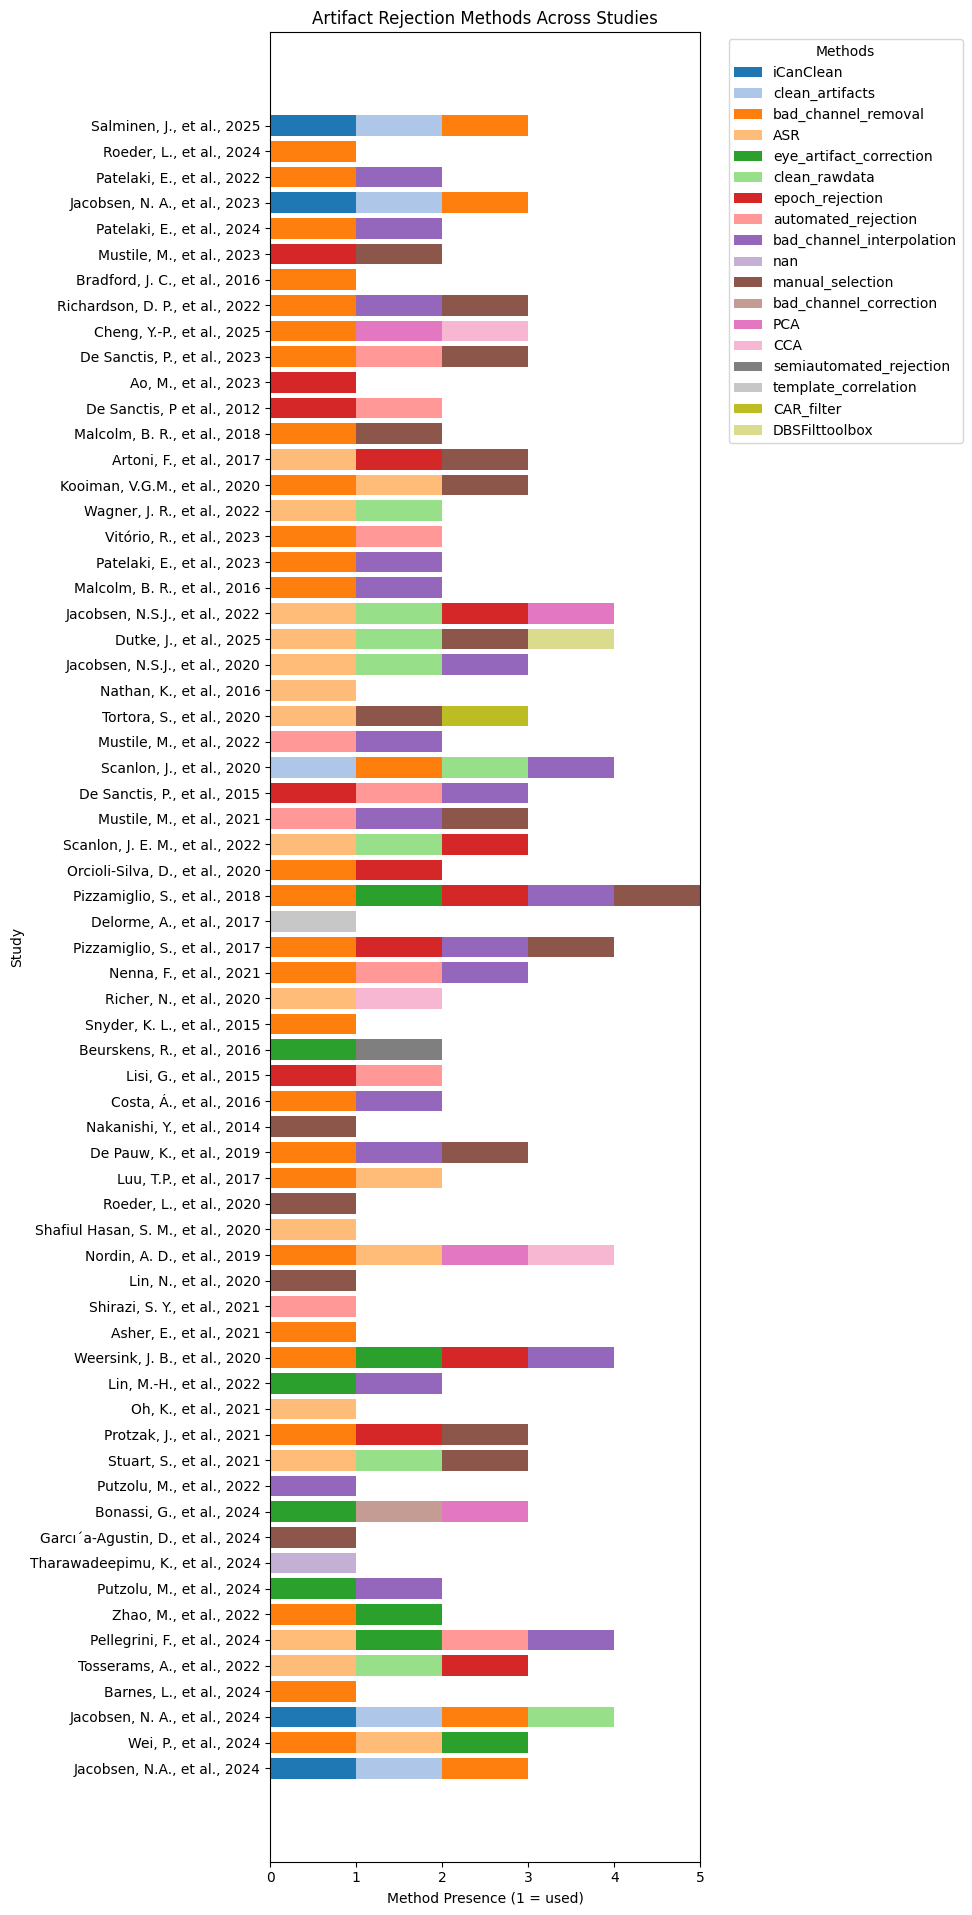

In [70]:
df_artifact = pd.read_csv(os.path.join(dir_processed, "Artifact_Methods_cleaned.csv"))
df_artifact["Citation"] = df_artifact["Citation"].fillna("Unknown Study")

methods = df_artifact["Artifactrej_methods"].unique()
pivot = pd.DataFrame(0, index=df_artifact["Citation"].unique(), columns=methods)

for title, group in df_artifact.groupby("Citation"):
    for m in group["Artifactrej_methods"]:
        pivot.loc[title, m] = 1

# Horizontal stacked bars
plt.figure(figsize=(10, len(pivot) * 0.25 + 3))
bottoms = np.zeros(len(pivot))
colors = sns.color_palette("tab20", n_colors=len(methods))

for i, method in enumerate(pivot.columns):
    plt.barh(pivot.index, pivot[method], left=bottoms, color=colors[i], label=method)
    bottoms += pivot[method].values

plt.xlabel("Method Presence (1 = used)")
plt.ylabel("Study")
plt.title("Artifact Rejection Methods Across Studies")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Methods")
plt.tight_layout()
plt.show()


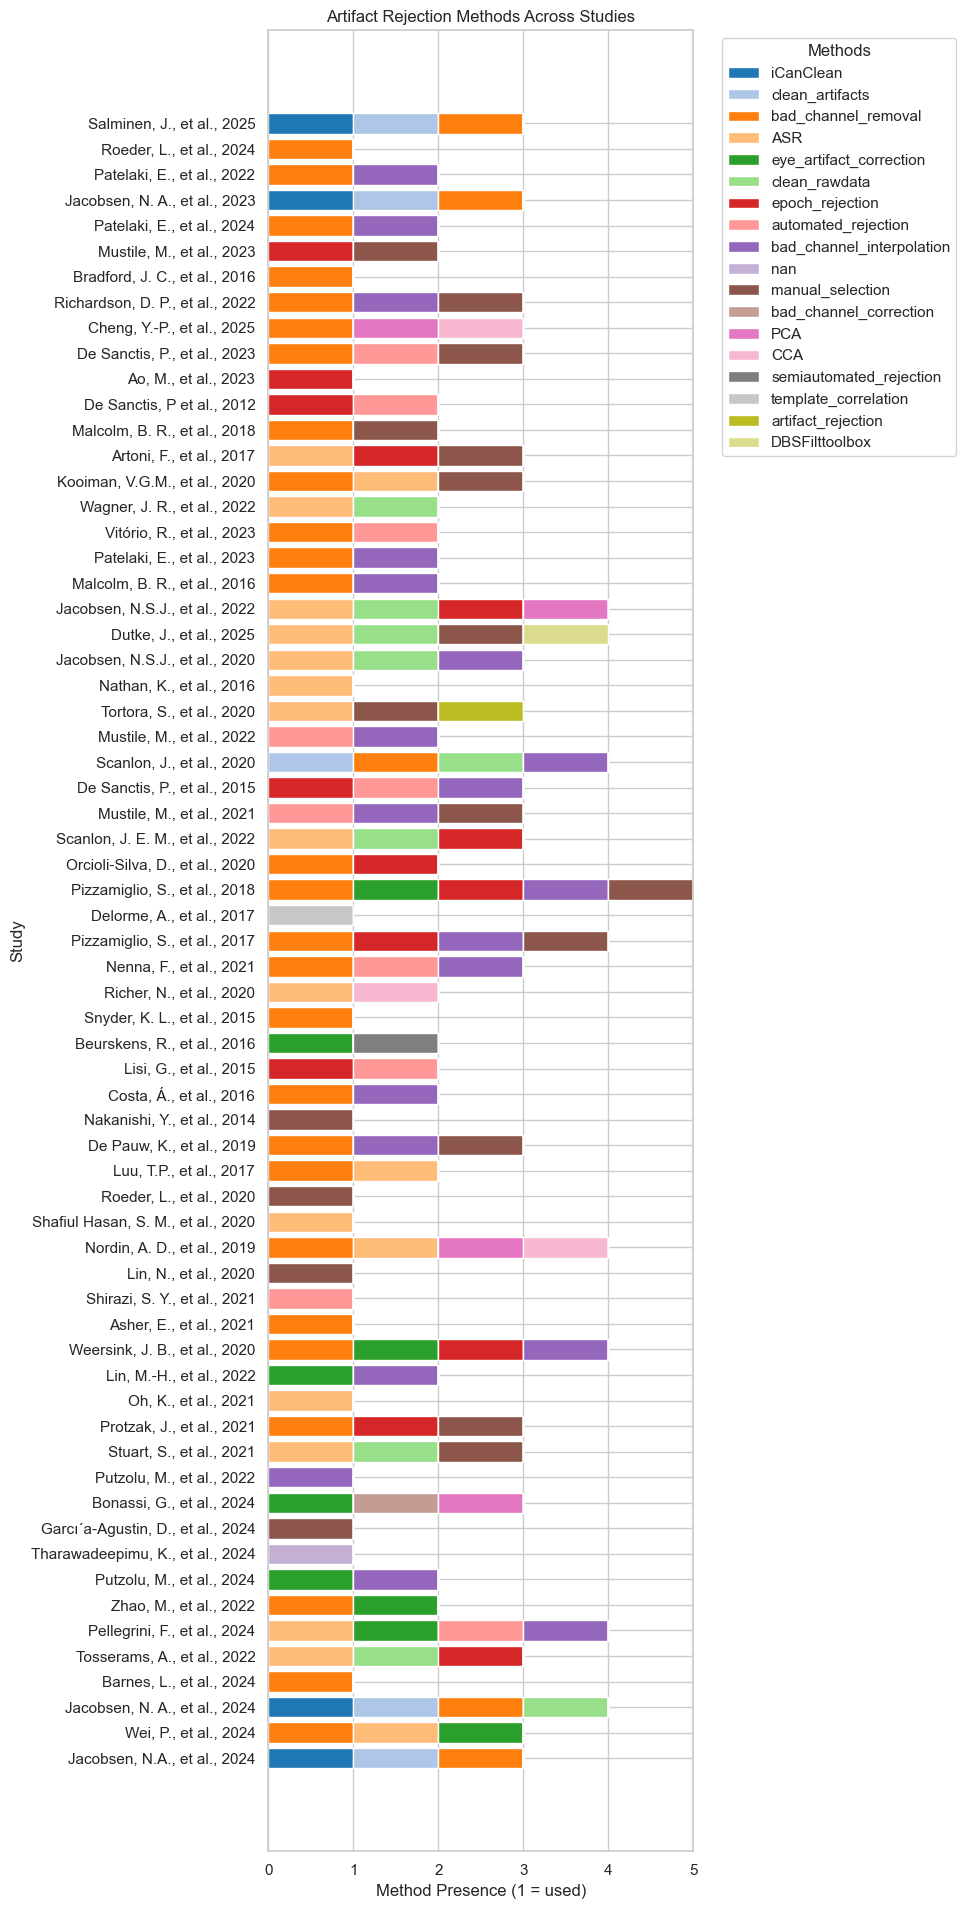

In [42]:
df_artifact = pd.read_csv(os.path.join(dir_processed, "Artifact_Methods_cleaned.csv"))
df_artifact["Citation"] = df_artifact["Citation"].fillna("Unknown Study")

methods = df_artifact["Artifactrej_methods"].unique()
pivot = pd.DataFrame(0, index=df_artifact["Citation"].unique(), columns=methods)

for title, group in df_artifact.groupby("Citation"):
    for m in group["Artifactrej_methods"]:
        pivot.loc[title, m] = 1

# Horizontal stacked bars
plt.figure(figsize=(10, len(pivot) * 0.25 + 3))
bottoms = np.zeros(len(pivot))
colors = sns.color_palette("tab20", n_colors=len(methods))

for i, method in enumerate(pivot.columns):
    plt.barh(pivot.index, pivot[method], left=bottoms, color=colors[i], label=method)
    bottoms += pivot[method].values

plt.xlabel("Method Presence (1 = used)")
plt.ylabel("Study")
plt.title("Artifact Rejection Methods Across Studies")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Methods")
plt.tight_layout()
plt.show()


In [ ]:
meta.to_csv("Combined_Metadata.csv", index=False)
print("Combined dataset saved as Combined_Metadata.csv")


✅ Combined dataset saved as Combined_Metadata.csv
